In [ ]:
from pkg.src.core import data, Optimizer
import numpy as np

# prices = data.get_prices("SPY, AGG, BND, GLD, GSG, ACWI, XLY")
# specific_constraints = [
#     {"assets" : ["ACWI", "SPY"], "bounds" : {0.5, None}},
#     {"assets" : ["GLD"], "bounds" : {None, 0.10}},
# ]

# opt = Optimizer.from_prices(prices=prices, weight_bounds=(0.05, 1.0)).set_specific_constraints(
#     specific_constraints=specific_constraints
# )
# opt.hierarchical_equal_risk_contribution()

import pandas as pd


def get_vix() -> pd.DataFrame:
    return data.get_macro(tickers="VIXCLS, GVZCLS")


data = get_vix()

data.plot()

In [ ]:

from pkg.src.core import signals, data
import pandas as pd

df = data.get_oecd_us_leading_indicator()
df.index = df.index + pd.DateOffset(months=1)
df = df.resample("M").last().dropna()

df = df.diff()
mean = df.rolling(12 * 5).mean()
std = df.rolling(12 * 5).std()
normalized = (df - mean) / std

normalized = normalized.clip(-3, 3).dropna()

import plotly.graph_objects as go


# Create the bar plot
fig = go.Figure(data=go.Bar(x=normalized.index, y=normalized["USALOLITONOSTSAM"]))

# Customize the plot layout
fig.update_layout(
    title='Bar Plot',
    xaxis_title='Categories',
    yaxis_title='Values'
)

# Display the plot
fig.show()


In [ ]:
normalized

In [ ]:
trend.loc['2015']

<AxesSubplot:>

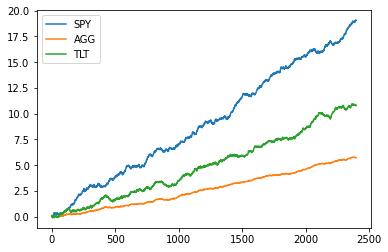

In [33]:
from pkg.src.core import data, metrics
import numpy as np
import pandas as pd
total_iter = 12 * 20 * 10
prices = data.get_prices("SPY, AGG, TLT").resample("M").last()

log_return = metrics.to_log_return(prices=prices)
expected_return = log_return.mean()
expected_riks = log_return.std()
cov = log_return.cov()
corr_cov = np.linalg.cholesky(cov)
z = np.random.normal(0, 1, size=(len(prices.columns), total_iter))

drift = np.full((total_iter, len(prices.columns)), expected_return).T
shock = np.dot(corr_cov, z)

monthly_returns = drift + shock
pd.DataFrame(
    np.transpose(monthly_returns),
    columns=prices.columns,
    # index=pd.date_range(start="2023-6-8", periods=total_iter, freq="M"),
).cumsum().plot()

(24000, 3)

In [ ]:
import pandas as pd


def to_macd(
    prices: pd.DataFrame,
    fast_window: int = 12,
    slow_window: int = 26,
    signal_window: int = 9,
) -> pd.DataFrame:
    MACD = (
        +prices.ewm(span=fast_window, min_periods=fast_window).mean()
        - prices.ewm(span=slow_window, min_periods=slow_window).mean()
    )
    signal = MACD.ewm(span=signal_window, min_periods=slow_window).mean()

    return signal


to_macd(prices).loc["2022"].plot()

In [ ]:
(
    prices.ewm(span=12, min_periods=12).mean()
    - prices.ewm(span=26, min_periods=26).mean()
).plot()

In [ ]:
yield_curve = {"T10Y2Y": "10Y-2Y", "T10Y3M": "10Y-3M"}

yield_curve_data = data.get_macro(list(yield_curve.keys())).loc["2019":]
yield_curve_data = yield_curve_data.rename(columns=yield_curve)
yield_curve_data.head().to_markdown()

In [ ]:
import plotly_express as px

px.line(yield_curve_data)

In [ ]:
my_list = [10, 20, 30, 40, 50]

# Get the index of a value in the list
value = 30

if value in my_list:
    index = my_list.index(value)
    print("Index of", value, "in the list:", index)
else:
    print(value, "is not present in the list.")

In [ ]:
from pkg.src.core.factors import price_momentum_diffusion
from pkg.src.core import data

price_momentum_diffusion(tickers="SPY, ACWI, XLY, XLP, AGG")

In [ ]:
from pkg.src.core import metrics
import numpy as np
import pandas as pd

prices = data.get_prices(tickers="SPY, ACWI, XLY, XLP, AGG")
momentums = (
    pd.concat(
        objs=[
            metrics.rolling.to_momentum(prices=prices, months=1).stack(),
            metrics.rolling.to_momentum(prices=prices, months=2).stack(),
            metrics.rolling.to_momentum(prices=prices, months=3).stack(),
            metrics.rolling.to_momentum(prices=prices, months=6).stack(),
            metrics.rolling.to_momentum(prices=prices, months=9).stack(),
            metrics.rolling.to_momentum(prices=prices, months=12).stack(),
        ],
        axis=1,
    )
    .apply(np.sign)
    .sum(axis=1)
    .unstack()
)

momentums

In [ ]:
from pkg.src.core import factors

factors.volatility_3m(tickers="SPY, AGG")

In [ ]:
from pkg.src.core import data

data.get_universe()

In [ ]:
from pkg.src.core.metrics.rolling import to_momentum
from pkg.src.core import data
from pkg.src.core.strategies import BacktestManager
import pandas as pd
from scipy.stats import norm


def to_standard_scalar(features: pd.Series) -> pd.Series:
    scalar = (features - features.mean()) / features.std()
    return scalar


def to_standard_percentile(features: pd.Series) -> pd.Series:
    return to_standard_scalar(features=features).aggregate(norm.cdf)


prices = data.get_prices("XLC, XLY, XLP, XLE, XLF, XLV, XLI, XLB, XLRE, XLK, XLU")

bt = BacktestManager(prices=prices)
features = to_momentum(prices=prices, months=12).apply(to_standard_percentile, axis=1)

bt.Base(name="Strategy1", start="2013-1-1", features=features, percentile=0.8)
#
bt.strategies["Strategy1"].allocations
# features
bt.strategies["Strategy1"].value.plot()

In [ ]:
from pkg.src.core import feature

functions = [func for func in dir(feature) if callable(getattr(feature, func))]
functions

In [ ]:
pri_momentum = data.price_momentum_1m(tickers="SPY, AGG")
pri_momentum

In [ ]:
import json

# from core.signals import OECDUSLEIHP
from pkg.core.strategies import BacktestManager

# signal = OECDUSLEIHP.from_fred_data()


def get_universe(name: str = "USSECTOR"):
    with open("universe.json") as f:
        return json.load(f).get(name)


from pkg.src.core import data

prices = data.get_prices(tickers=list(get_universe().keys()))
bt = BacktestManager(prices=prices, start="2007-1-1", commission=10, shares_frac=0)
# bt.Momentum(target_percentile=0.7, months=3)
# bt.values.plot(figsize=(12, 10))
# bt.analytics

from core import metrics

metrics.to_momentum(prices=prices.iloc[:, 0], months=12, skip_months=1)

In [ ]:
from pkg.src.core import data


data.get_universe()

In [ ]:
opt = Optimizer.from_prices(prices=prices.loc["2017"].dropna(axis=1))

w = opt.hierarchical_risk_parity()

w

In [ ]:
from pkg.src.core.portfolios import objectives

np.sum(
    objectives.risk_contributions(
        weights=w,
        covariance_matrix=np.array(opt.covariance_matrix),
        sub_covariance_matrix_idx=[8],
    )
)

np.sum(
    objectives.risk_contributions(
        weights=w,
        covariance_matrix=np.array(opt.covariance_matrix),
        sub_covariance_matrix_idx=[0, 3],
    )
)

In [ ]:
objectives.expected_volatility(w, opt.covariance_matrix)

In [ ]:
dist = np.sqrt((1 - opt.correlation_matrix).round(5) / 2)
clusters = linkage(squareform(dist), method="single")
sorted_tree = list(to_tree(clusters, rd=False).pre_order())

print(sorted_tree)


def recursive_bisection(sorted_tree):
    """_summary_

    Args:
        sorted_tree (_type_): _description_

    Returns:
        List[Tuple[List[int], List[int]]]: _description_
    """

    left = sorted_tree[0 : int(len(sorted_tree) / 2)]
    right = sorted_tree[int(len(sorted_tree) / 2) :]

    if len(sorted_tree) < 3:
        return (left, right)

    cache = [(left, right)]
    if len(left) > 2:
        cache.extend(recursive_bisection(left))
    if len(right) > 2:
        cache.extend(recursive_bisection(right))
    return cache


cluster_sets = recursive_bisection(sorted_tree)

for i in cluster_sets:
    print(i)

In [ ]:
from core import data
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tickers = {
    "T5YIE": "Breakeven Inflation: 5Y",
    "T10YIE": "Breakeven Inflation: 10Y",
    "T5YIFR": "Expectation Infaltiona: 5Y",
}

result = data.get_macro(tickers=tickers).dropna()
result["chg"] = result["Breakeven Inflation: 10Y"] - result["Breakeven Inflation: 5Y"]
spy = data.get_prices(tickers="SPY")

# Create a line plot for each series
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)
fig.add_trace(
    go.Scatter(x=spy.index, y=spy["SPY"], mode="lines", name="SPY"), row=1, col=1
)
for series in result:
    fig.add_trace(
        go.Scatter(x=result.index, y=result[series], mode="lines", name=series),
        row=2,
        col=1,
    )

# Set the title and axis labels
fig.update_layout(title="Inflation", xaxis_title="Date", yaxis_title="%", height=600)
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=False),
        type="date",
    ),
    hovermode="x unified",  # Enable the "Show All Stats" option on mouseover
)

# Display the graph
fig.show()

In [ ]:
from core.strategies import BacktestManager

bt = BacktestManager.from_universe(start="2010-1-1", commission=10, shares_frac=0)
bt.Momentum()
bt.values.plot()